Import Library

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import os
import cv2
from skimage import exposure
from sklearn.model_selection import train_test_split
import shutil
import zipfile
from PIL import Image

Load Data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"analativach221111009","key":"6976a8e12ea0ae8344e69caf6ec7d4cb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
os.environ['KAGGLE_USERNAME'] = "analativach221111009"
os.environ['KAGGLE_KEY'] = "6976a8e12ea0ae8344e69caf6ec7d4cb"
!kaggle datasets download -d analativach221111009/braintumor-mri-datasets

Dataset URL: https://www.kaggle.com/datasets/analativach221111009/braintumor-mri-datasets
License(s): unknown
100% 148M/149M [00:09<00:00, 20.4MB/s]
100% 149M/149M [00:09<00:00, 15.8MB/s]


In [ ]:
# Tentukan path ke file ZIP
zip_file_path = 'braintumor-mri-datasets.zip'

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('finalproject_datasets')  # Folder tujuan tempat gambar diekstrak

In [ ]:
# Path ke folder yang berisi dataset
data_dir = 'finalproject_datasets/Training'
test_dir = 'finalproject_datasets/Testing'

In [ ]:
# Menghitung total data

import os

def count_dataset_files(directory):

  total_files = 0
  for root, _, files in os.walk(directory):
    total_files += len(files)
  return total_files

total_test_files = count_dataset_files(data_dir)
print(f"Total files in training dataset: {total_test_files}")

total_train_files = count_dataset_files(test_dir)
print(f"Total files in testing dataset: {total_train_files}")

total_dir = total_train_files + total_test_files
print(f"Total files in dataset: {total_dir}")

Total files in training dataset: 5712
Total files in testing dataset: 1311
Total files in dataset: 7023


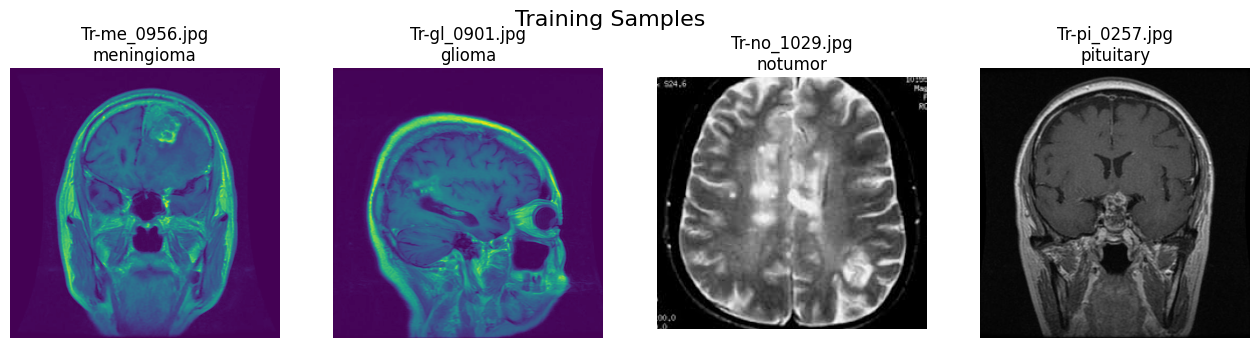

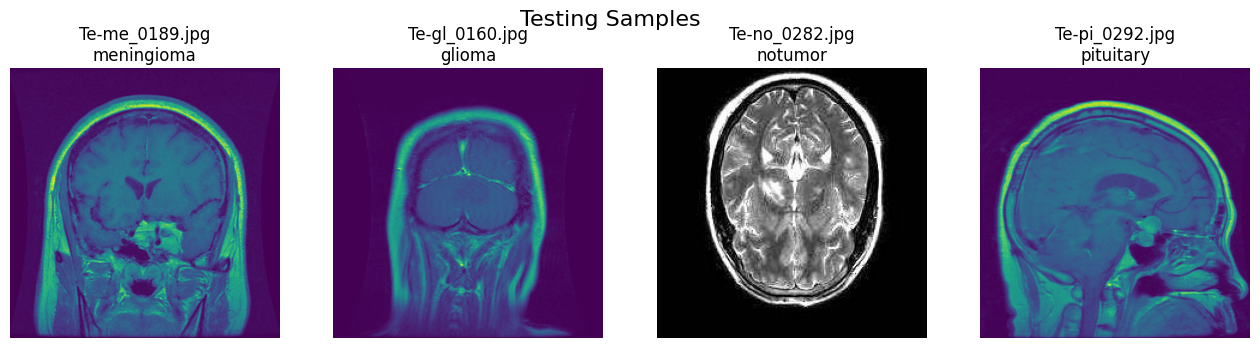

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Fungsi untuk menampilkan 1 gambar dari setiap subfolder dalam direktori yang ditentukan
def display_samples_from_subfolders(directory, title):
    # Dapatkan semua subfolder di dalam direktori
    subfolders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    sample_images = []

    # Ambil satu gambar dari setiap subfolder
    for subfolder in subfolders:
        all_images = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if all_images:
            sample_images.append(random.choice(all_images))  # Pilih satu gambar acak

    # Set ukuran plot
    plt.figure(figsize=(16, 4))  # Ukuran lebih besar untuk 4 gambar sejajar
    plt.suptitle(title, fontsize=16)

    # Tampilkan setiap gambar yang dipilih
    for i, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        plt.subplot(1, 4, i + 1)  # Mengatur 4 gambar dalam 1 baris
        plt.imshow(img)
        plt.axis('off')

        # Mendapatkan jenis tumor dari nama subdirektori
        tumor_type = os.path.basename(os.path.dirname(img_path))  # Mengambil nama subdirektori
        plt.title(f"{os.path.basename(img_path)}\n{tumor_type}")  # Menambahkan keterangan jenis tumor

    plt.show()

# Tampilkan 1 contoh gambar dari setiap subfolder dalam direktori Testing dan Training
display_samples_from_subfolders(data_dir, "Training Samples")
display_samples_from_subfolders(test_dir, "Testing Samples")

Preprocess

In [ ]:
# Hapus Duplikat
import os
import hashlib
from PIL import Image
import contextlib

def calculate_hash(image_path):
    with Image.open(image_path) as img:
        # Menghitung hash dari konten gambar
        hash_md5 = hashlib.md5(img.tobytes()).hexdigest()
    return hash_md5

# Path ke folder dataset
dataset_path = 'finalproject_datasets'

# Dictionary untuk menyimpan hash gambar yang sudah ditemukan
hashes = {}
duplicate_count = 0  # Inisialisasi di awal

# Membungkam output
with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull):  # Mengarahkan stdout ke null
        # Looping untuk memeriksa setiap file di folder dataset
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                file_path = os.path.join(root, file)

                try:
                    # Hitung hash dari gambar
                    file_hash = calculate_hash(file_path)

                    # Jika hash sudah ada di dictionary, hapus file duplikat
                    if file_hash in hashes:
                        os.remove(file_path)
                        duplicate_count += 1  # Tambahkan ke count
                    else:
                        # Jika tidak ada, tambahkan ke dictionary
                        hashes[file_hash] = file_path
                except Exception as e:
                    pass  # Abaikan error tanpa mencetaknya

# Setelah proses duplikasi, hitung total file yang tersisa setelah pembersihan
total_files_left = sum([len(files) for _, _, files in os.walk(dataset_path)])

# Menampilkan hasil
print(f"Total file duplikat yang dihapus: {duplicate_count}")
print(f"Total file yang tersisa di dataset: {total_files_left}")

Total file duplikat yang dihapus: 426
Total file yang tersisa di dataset: 6597


In [ ]:
import os

# Path ke folder dataset
training_path = 'finalproject_datasets/Training'

# Dictionary untuk menyimpan jumlah file dalam setiap kelas
class_counts = {}

# Menghitung total file dan jumlah file berdasarkan kelas
total_files = 0

for root, dirs, files in os.walk(training_path):
    # Menghitung jumlah file dalam direktori ini
    total_files += len(files)

    # Menentukan nama kelas dari nama subfolder
    class_name = os.path.basename(root)

    # Jika folder bukan folder dataset, lanjutkan
    if class_name == os.path.basename(training_path):
        continue

    # Jika kelas belum ada dalam dictionary, tambahkan
    if class_name not in class_counts:
        class_counts[class_name] = 0

    # Menambahkan jumlah file ke kelas yang sesuai
    class_counts[class_name] += len(files)

# Menampilkan total file dan jumlah file per kelas
print(f"Total file di dalam folder dataset: {total_files}")
print("Jumlah file berdasarkan kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} file")

Total file di dalam folder dataset: 5505
Jumlah file berdasarkan kelas:
meningioma: 1333 file
glioma: 1321 file
notumor: 1406 file
pituitary: 1445 file


In [ ]:
# Normalisasi dan Peningkatan Kontras

import os
import cv2
import numpy as np
import gc


def enhance_contrast_histogram_equalization(image):
    """
    Tingkatkan kontras gambar menggunakan Histogram Equalization.
    Gambar harus dalam format grayscale.
    """
    return cv2.equalizeHist(image)


def enhance_contrast_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Tingkatkan kontras gambar menggunakan CLAHE.
    Gambar harus dalam format grayscale.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)


def normalize_and_enhance_contrast(input_folder, output_folder, method="clahe", clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Normalisasi dan tingkatkan kontras semua gambar di folder dan subfolder.

    Parameters:
    - input_folder: Folder input yang berisi gambar.
    - output_folder: Folder untuk menyimpan gambar hasil.
    - method: Metode kontras yang digunakan ("histogram" atau "clahe").
    - clip_limit, tile_grid_size: Parameter untuk CLAHE.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Path gambar input dan folder output
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_folder)
                output_subdir = os.path.join(output_folder, relative_path)

                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                output_path = os.path.join(output_subdir, file)

                try:
                    # Baca gambar sebagai grayscale
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is None:
                        print(f"Gambar tidak dapat dibaca: {image_path}")
                        continue

                    # Normalisasi piksel ke rentang [0, 1]
                    normalized_image = image.astype(np.float32) / 255.0

                    # Kembalikan ke rentang [0, 255] untuk peningkatan kontras
                    normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

                    # Tingkatkan kontras
                    if method == "histogram":
                        enhanced_image = enhance_contrast_histogram_equalization(normalized_image_uint8)
                    elif method == "clahe":
                        enhanced_image = enhance_contrast_clahe(normalized_image_uint8, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
                    else:
                        raise ValueError("Metode kontras tidak valid. Gunakan 'histogram' atau 'clahe'.")

                   # Simpan gambar hasil tanpa mencetak pesan ke layar
                    cv2.imwrite(output_path, enhanced_image)

                    # Bersihkan memori
                    del image, normalized_image, normalized_image_uint8, enhanced_image
                    gc.collect()

                except Exception as e:
                    continue  # Error silenced dan proses dilanjutkan

# Contoh penggunaan
input_folder = 'finalproject_datasets'
output_folder = 'NormalizationEnhanced'
normalize_and_enhance_contrast(input_folder, output_folder, method="clahe", clip_limit=2.0, tile_grid_size=(8, 8))

In [ ]:
# K-Means Segmentation

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc  # Library untuk pengelolaan memori

def kmeans_segmentation(image, k=4):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels].reshape(image.shape)
    return segmented_image

def process_folder_with_kmeans(input_folder, output_folder, k=4):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)

                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)

                try:
                    image = cv2.imread(image_path)
                    if image is None:
                        continue

                    segmented_image = kmeans_segmentation(image, k=k)
                    output_path = os.path.join(output_subfolder, f"kmeans_{file}")
                    cv2.imwrite(output_path, segmented_image)

                    # Hapus gambar dari memori
                    del image
                    del segmented_image
                    gc.collect()  # Panggil garbage collector untuk membersihkan memori

                except Exception as e:
                    pass  # Tidak menampilkan error

# Contoh penggunaan
input_folder = 'NormalizationEnhanced'
output_folder = 'Kmeans'
k_clusters = 4

process_folder_with_kmeans(input_folder, output_folder, k=k_clusters)

Train Model

Jumlah data: 5505


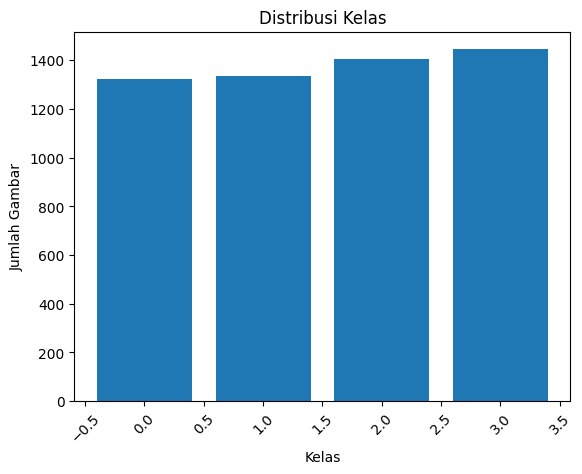

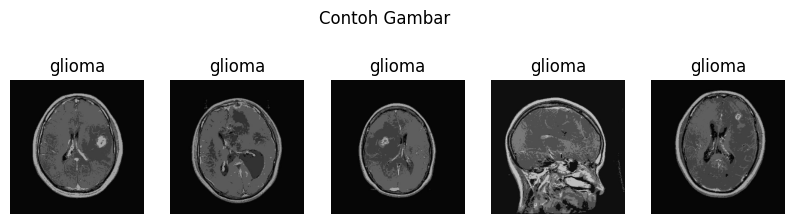

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 827s 3s/step - accuracy: 0.7157 - loss: 0.7284 - val_accuracy: 0.5800 - val_loss: 1.1733
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - accuracy: 0.9331 - loss: 0.1880 - val_accuracy: 0.5636 - val_loss: 1.8186
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 829s 3s/step - accuracy: 0.9670 - loss: 0.0923 - val_accuracy: 0.7600 - val_loss: 0.8558
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.9850 - loss: 0.0464 - val_accuracy: 0.8255 - val_loss: 0.7159
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 801s 3s/step - accuracy: 0.9804 - loss: 0.0561 - val_accuracy: 0.7782 - val_loss: 1.4384
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 776s 3s/step - accuracy: 0.9870 - loss: 0.0328 - val_accuracy: 0.8873 - val_loss: 0.5912
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 771s 3s/step - accuracy: 0.9910 - loss: 0.0277 - val_accuracy: 0.8782 - val_loss: 0.6599
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.97      0.97       148
  meningioma       0.92      0.94      0.93       123
     notumor       0.99      0.97      0.98       147
   pituitary       0.98      0.97      0.98       133

    accuracy                           0.97       551
   macro avg       0.96      0.96      0.96       551
weighted avg       0.97      0.97      0.97       551

Confusion Matrix:
[[144   4   0   0]
 [  4 116   1   2]
 [  1   3 143   0]
 [  1   3   0 129]]
True Positives: [144 116 143 129]
True Negatives: [397 418 403 416]
False Positives: [ 6 10  1  2]
False Negatives: [4 7 4 4]


In [ ]:
# MobileNetV2 lr 0.0001, epochs=30, batch_size=16
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV2  # Menggunakan MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping

# Fungsi untuk load gambar
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)

    # Pemetaan label sesuai dengan klasifikasi tumor
    label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (224, 224))  # Resize image to match model input
                    images.append(img)
                    labels.append(label_map[class_name])  # Gunakan pemetaan label

    return np.array(images), np.array(labels)

# Fungsi untuk plot distribusi kelas
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Fungsi untuk menampilkan contoh gambar
def plot_examples(images, labels, label_names, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):  # Menampilkan 5 gambar contoh
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(label_names[labels[i]])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Fungsi utama untuk training dan evaluasi model
def main():
    input_folder = 'Kmeans/Training'  # Path ke folder dataset

    # Load images
    images, labels = load_images_from_folder(input_folder)

    print(f"Jumlah data: {len(images)}")

    # Pemetaan label numerik ke nama kelas
    label_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    # Plot distribusi kelas
    plot_class_distribution(labels, 'Distribusi Kelas')

    # Tampilkan contoh gambar
    plot_examples(images, labels, label_names, 'Contoh Gambar')

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)  # 80% training
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing

    # Prepare the MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Menggunakan MobileNetV2
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))  # Menambahkan dropout untuk mengurangi overfitting
    model.add(Dense(4, activation='softmax'))  # Sesuaikan dengan 4 kelas: glioma, meningioma, notumor, pituitary

    # Compile model dengan learning rate
    learning_rate = 0.0001  # Bisa disesuaikan dengan kebutuhan
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Convert predictions to class names
    y_pred_names = [label_names[label] for label in y_pred]

    # Display classification report with class names
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[label_names[i] for i in range(4)]))

    # Confusion Matrix (dengan nama kelas)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Hitung TP, TN, FP, FN
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    # Save the model
    model.save('mobilenetv2_model.h5')

if __name__ == "__main__":
    main()

Jumlah data: 5505


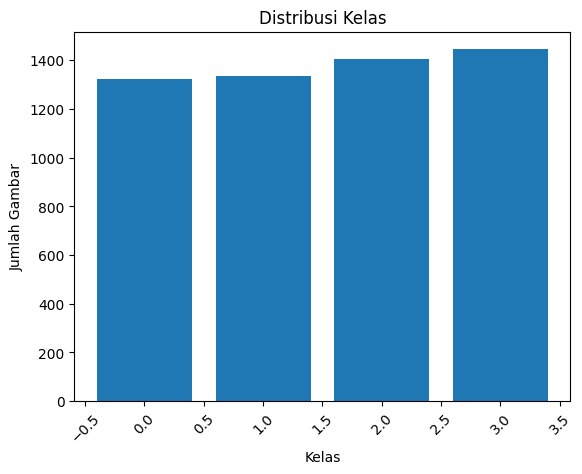

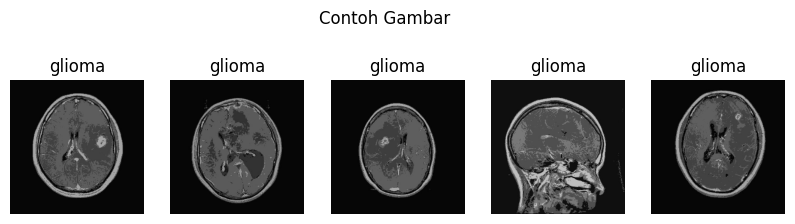

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1438s 5s/step - accuracy: 0.7061 - loss: 0.7530 - val_accuracy: 0.8600 - val_loss: 0.4009
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1368s 5s/step - accuracy: 0.9287 - loss: 0.2071 - val_accuracy: 0.9273 - val_loss: 0.2104
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1404s 5s/step - accuracy: 0.9571 - loss: 0.1202 - val_accuracy: 0.9491 - val_loss: 0.1402
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1433s 5s/step - accuracy: 0.9795 - loss: 0.0816 - val_accuracy: 0.9673 - val_loss: 0.1195
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1394s 5s/step - accuracy: 0.9820 - loss: 0.0519 - val_accuracy: 0.9709 - val_loss: 0.0808
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1396s 5s/step - accuracy: 0.9867 - loss: 0.0384 - val_accuracy: 0.9727 - val_loss: 0.0660
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1396s 5s/step - accuracy: 0.9877 - loss: 0.0362 - val_accuracy: 0.9855 - val_loss: 0.0469
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       148
  meningioma       0.96      0.93      0.95       123
     notumor       0.98      1.00      0.99       147
   pituitary       0.98      0.98      0.98       133

    accuracy                           0.98       551
   macro avg       0.98      0.97      0.98       551
weighted avg       0.98      0.98      0.98       551

Confusion Matrix:
[[145   3   0   0]
 [  3 115   3   2]
 [  0   0 147   0]
 [  0   2   0 131]]
True Positives: [145 115 147 131]
True Negatives: [400 423 401 416]
False Positives: [3 5 3 2]
False Negatives: [3 8 0 2]


In [ ]:
# EfficientNetB0
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0  # Menggunakan EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping

# Fungsi untuk load gambar
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)

    # Pemetaan label sesuai dengan klasifikasi tumor
    label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (224, 224))  # Resize image to match model input
                    images.append(img)
                    labels.append(label_map[class_name])  # Gunakan pemetaan label

    return np.array(images), np.array(labels)

# Fungsi untuk plot distribusi kelas
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Fungsi untuk menampilkan contoh gambar
def plot_examples(images, labels, label_names, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):  # Menampilkan 5 gambar contoh
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(label_names[labels[i]])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Fungsi utama untuk training dan evaluasi model
def main():
    input_folder = 'Kmeans/Training'  # Path ke folder dataset

    # Load images
    images, labels = load_images_from_folder(input_folder)

    print(f"Jumlah data: {len(images)}")

    # Pemetaan label numerik ke nama kelas
    label_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    # Plot distribusi kelas
    plot_class_distribution(labels, 'Distribusi Kelas')

    # Tampilkan contoh gambar
    plot_examples(images, labels, label_names, 'Contoh Gambar')

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)  # 80% training
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing

    # Prepare the EfficientNetB0 model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Menggunakan EfficientNetB0
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))  # Menambahkan dropout untuk mengurangi overfitting
    model.add(Dense(4, activation='softmax'))  # Sesuaikan dengan 4 kelas: glioma, meningioma, notumor, pituitary

    # Compile model dengan learning rate
    learning_rate = 0.0001  # Bisa disesuaikan dengan kebutuhan
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Convert predictions to class names
    y_pred_names = [label_names[label] for label in y_pred]

    # Display classification report with class names
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[label_names[i] for i in range(4)]))

    # Confusion Matrix (dengan nama kelas)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Hitung TP, TN, FP, FN
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    # Save the model
    model.save('efficientnetb0_tumor_model.h5')

if __name__ == "__main__":
    main()

In [ ]:
# GoogleNet
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Fungsi untuk load gambar
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)

    # Pemetaan label sesuai dengan klasifikasi tumor
    label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (224, 224))  # Resize image to match model input size
                    images.append(img)
                    labels.append(label_map[class_name])  # Gunakan label_map untuk konversi label

    return np.array(images), np.array(labels)

def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_examples(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def main():
    input_folder = 'Kmeans/Training'

    # Load images
    images, labels = load_images_from_folder(input_folder)

    print(f"Jumlah data: {len(images)}")

    # Plot distribusi kelas
    plot_class_distribution(labels, 'Distribusi Kelas')

    # Tampilkan contoh gambar
    plot_examples(images, labels, 'Contoh Gambar')

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)  # 80% training
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing

    # Prepare the InceptionV3 model (GoogleNet)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Ganti ke InceptionV3
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))  # Menambahkan dropout untuk mengurangi overfitting
    model.add(Dense(4, activation='softmax'))  # Sesuaikan dengan 4 kelas: glioma, meningioma, notumor, pituitary

    # Compile model dengan learning rate
    learning_rate = 0.0001  # Sesuaikan learning rate sesuai kebutuhan
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model with validation data
    model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Simpan hasil prediksi untuk digunakan dalam ensemble
    predictions_googlenet = y_pred

    # Display evaluation metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Hitung TP, TN, FP, FN
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    # Save the model
    model.save('GoogleNet.h5')

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import files
files.download("efficientnetb0_tumor_model.h5")